
Прогнозирование с помощью Prophet

In [ ]:
!pip install fbprophet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
from fbprophet import Prophet

In [ ]:
df = pd.read_csv('benzak_01.csv', sep=';')
df.head()

,ds,y
0,2146-01-01,5510.0
1,2146-01-02,8617.0
2,2146-01-03,12553.0
3,2146-01-04,12513.0
4,2146-01-05,11170.0


Построим график, чтобы определится с параметрами модели

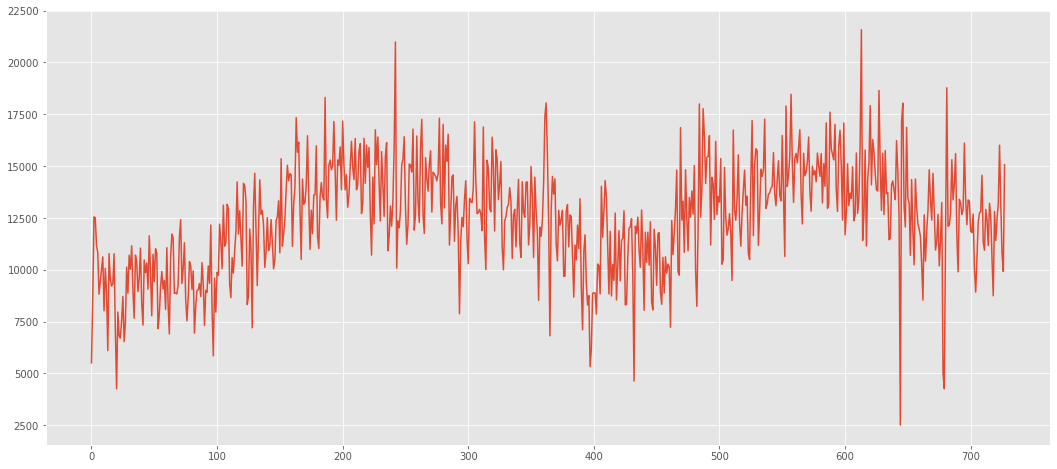

In [ ]:
plt.figure(figsize=(18, 8))
plt.plot(df['y'])

1. Аддитивная сезонность
2. Тренд кусочно-линейный
3. Характер не меняет
4. Имеются выбросы
5. Пропущенных значений нет 

#Часть 1. Замена выбросов

Делаем прогноз для исходных данных

In [ ]:
horizon_ = 60

Внутридневная сезонность False, т.к. данные по дням, а не по часам. Остальное в соответсвии с выводами над первым графиком.

In [ ]:
m_for_blowout = Prophet(growth='linear', changepoints=None, yearly_seasonality= True, weekly_seasonality= True,
            daily_seasonality=False, seasonality_mode='additive')
m_for_blowout.fit(df)

In [ ]:
#Оставляем даты
forecast_2 = m_for_blowout.make_future_dataframe(periods=horizon_)
#Прогнозируем для имеющихся дат
forecast_3 = m_for_blowout.predict(forecast_2)

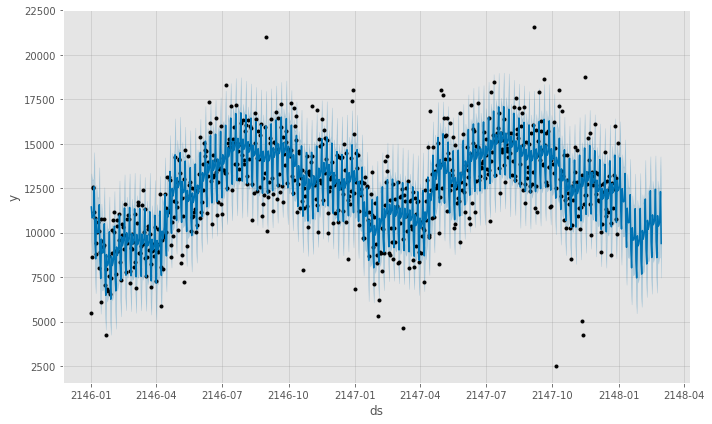

In [ ]:
fig1 = m_for_blowout.plot(forecast_3)

Найдем и заменим выбросы. Для этого используем ящик с усами (заменяем то что ниже/выше 1/3 квантиля соответственно). Заменяем на значения, полученные при прогнозировании имеющихся дат.

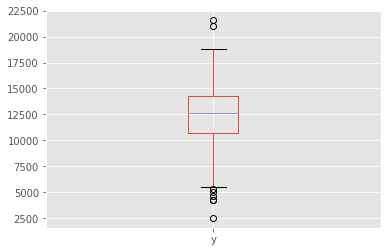

In [ ]:
df.boxplot(['y'])

In [ ]:
for x in ['y']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
    blowout_low = df[x] < min,x
    blowout_hight = df[x] > max,x

In [ ]:
for i in range(728):
  if blowout_low[0][i] or blowout_hight[0][i]:
    df['y'][i]=forecast_3['yhat'][i]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Смотрим результат, выбросы устранены

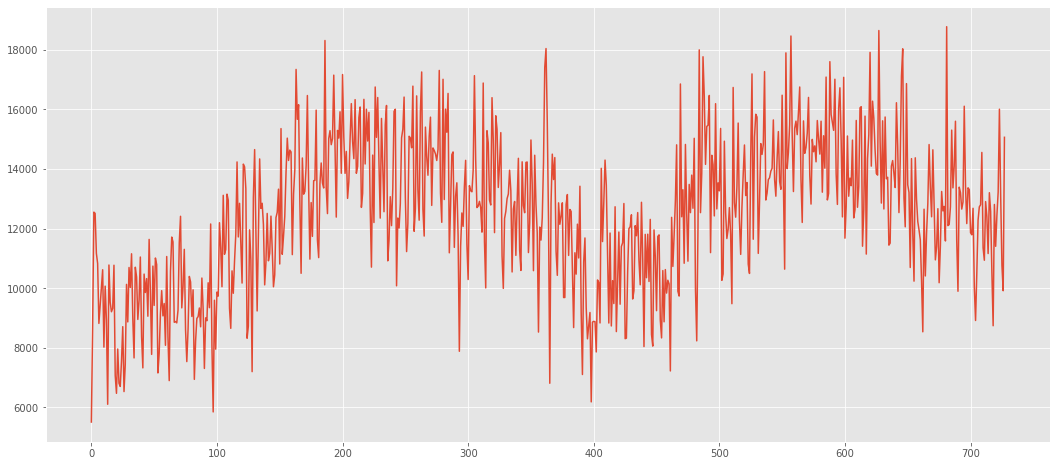

In [ ]:
plt.figure(figsize=(18, 8))
plt.plot(df['y'])

#Часть 2. Прогнозирование на обучающей и тестовой выборке.

In [ ]:
#НЕОБХОДИМО ДЛЯ ОЦЕНКИ КАЧЕСТВА МОДЕЛИ
#Количество дней для тренировки
train_length = len(df) - horizon_
#Делим на обучающее и тестовое множества 
df_train = df.iloc[0:train_length]
df_test = df.iloc[train_length:len(df)]

Обучаем модель

In [ ]:
m_for_quality = Prophet(growth='linear', changepoints=None, yearly_seasonality= True, weekly_seasonality= True,
            daily_seasonality=False, seasonality_mode='additive')
m_for_quality.fit(df_train)

Создаем даты

In [ ]:
forecast11 = m_for_quality.make_future_dataframe(periods=horizon_)

Прогнозируем 

In [ ]:
forecast12 = m_for_quality.predict(forecast11)
forecast = forecast12[['yhat']]

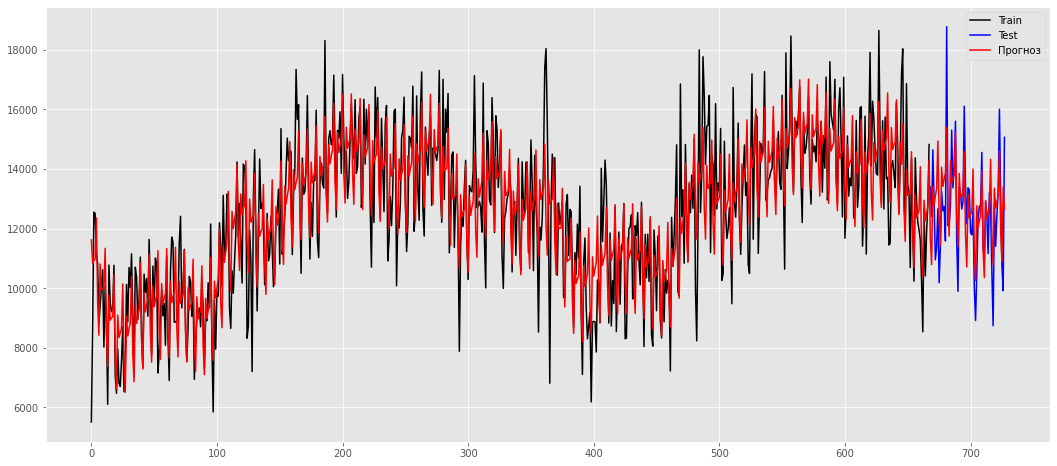

In [ ]:
#   Проверяем качество прогноза
#   Строим графики
plt.figure(figsize=(18, 8))
plt.plot(df_train['y'], label='Train', c = 'black')
plt.plot(df_test['y'], label='Test', c = 'blue')
plt.plot(forecast, label='Прогноз', c = 'red')
plt.legend(loc='best')


plt.show()

Оценим среднюю ошибку. Она оказалась не очень большой, все хорошо.

In [ ]:
MAPE_ARIMA = np.mean(np.abs((forecast['yhat'] - df_test['y'])/df_test['y']))*100
print("MAPE для ARIMA = ", MAPE_ARIMA, '%')

MAPE для ARIMA =  8.809027689807778 %


#Часть 3. Прогнозируем дальнейшие 60 дней 

In [ ]:
m_final = Prophet(growth='linear', changepoints=None, yearly_seasonality= True, weekly_seasonality= True,
            daily_seasonality=False, seasonality_mode='additive')
m_final.fit(df)

In [ ]:
#Создаем даты с учетом прогнозируемых 60 дней
forecast_4 = m_final.make_future_dataframe(periods=horizon_)

In [ ]:
#Прогнозируем
forecast_final = m_final.predict(forecast_4)

График исторических данных, подгонки и прогноза

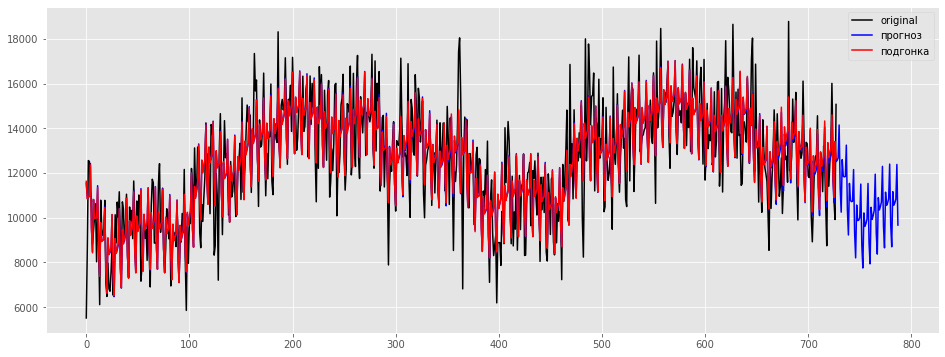

In [ ]:
plt.figure(figsize=(16, 6))

plt.plot(df['y'], label='original', c = 'black')
plt.plot(forecast_final['yhat'], label='прогноз', c = 'blue')
plt.plot(forecast, label='подгонка', c = 'red')
plt.legend(loc='best')


plt.show()